# Démonstration de l’utilisation de la bibliothèque `pyMDU`

Ce notebook a pour objectif de démontrer comment utiliser la bibliothèque `pymdu`

In [1]:
import os
import sys
from pathlib import Path

import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import rasterio.plot
from matplotlib import rcParams
from shapely.geometry import box

%matplotlib inline
rcParams['font.family'] = 'DejaVu Sans'

## Chemin de base vers l'environnement Micromamba / Conda

In [2]:
env_dir = Path.home() / 'miniforge3' / 'envs' / 'pymdu'
# env_dir = Path.home() / 'micromamba'/'envs'/'pymdu'

if sys.platform.startswith('win'):
    # Windows
    proj_lib_path = env_dir / 'Library' / 'share' / 'proj'
    gdalwarp_exe = env_dir / 'Library' / 'bin' / 'gdalwarp.exe'
    gdal_rasterize_exe = env_dir / 'Library' / 'bin' / 'gdal_rasterize.exe'
    bin_dir = env_dir / 'Library' / 'bin'
else:
    # Linux/macOS
    proj_lib_path = env_dir / 'share' / 'proj'
    gdalwarp_exe = env_dir / 'bin' / 'gdalwarp'
    # gdal_rasterize_exe = env_dir / 'bin' / 'gdal_rasterize'
    bin_dir = env_dir / 'bin'

# Application de la configuration
os.environ['PROJ_LIB'] = str(proj_lib_path)
GDALWARP_PATH = str(gdalwarp_exe)

## Chemin de base vers QGIS et ses plugins

In [3]:
if sys.platform.startswith('win'):
    # Windows
    qgis_python = env_dir / 'Library' / 'share' / 'qgis' / 'python'
    qgis_plugins = qgis_python / 'plugins'
    user_plugins = Path.home() / 'AppData' / 'Roaming' / 'QGIS' / 'QGIS3' / 'profiles' / 'default' / 'python' / 'plugins'
else:
    # Linux/macOS
    qgis_python = env_dir / 'share' / 'qgis' / 'python'
    qgis_plugins = qgis_python / 'plugins'
    user_plugins = Path.home() / '.local' / 'share' / 'QGIS' / 'QGIS3' / 'profiles' / 'default' / 'python' / 'plugins'

# Ajout des chemins à sys.path
for path in (qgis_python, qgis_plugins, user_plugins):
    sys.path.append(str(path.resolve()))

## Initialisation du dossier de simulation

In [4]:
inputs_simulation_path = os.path.join(os.getcwd(), 'results_demo/inputs_simulation')
os.makedirs(inputs_simulation_path, exist_ok=True)

output_path = os.path.join(os.getcwd(), 'results_demo')
os.makedirs(output_path, exist_ok=True)

output_path_urock = os.path.join(output_path, 'output_urock')
os.makedirs(output_path_urock, exist_ok=True)

# Sélection de votre zone d'intérêt

Tracez un rectangle sur la carte ci-dessous pour délimiter la région qui vous intéresse.

Une fois la sélection effectuée, cliquez sur le rectangle et copiez le texte généré.

In [5]:
from pymdu.commons.BasicFunctions import draw_bbox_with_folium

draw_bbox_with_folium(lat=46.160329,
                      lon=-1.151139,
                      zoom_start=13)


TEMP_PATH /var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T


Output()

## Chargement des données GeoJSON et calculer la bounding box

Copiez‐collez le JSON ci-dessous dans la variable `geojson_dict`.

Le script suivant extrait les coordonnées du polygone, détermine les longitudes et latitudes minimales et maximales, puis construit la liste `[minx, miny, maxx, maxy]`.


In [6]:
geojson_dict = {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [
    [[-1.155254, 46.155467], [-1.155254, 46.158503], [-1.148575, 46.158503], [-1.148575, 46.155467],
     [-1.155254, 46.155467]]]}}
# Extraire les coordonnées du polygone
coordinates = geojson_dict['geometry']['coordinates'][0]
# Calculer les valeurs min et max
minx = min([point[0] for point in coordinates])  # Minimum des longitudes (x)
miny = min([point[1] for point in coordinates])  # Minimum des latitudes (y)
maxx = max([point[0] for point in coordinates])  # Maximum des longitudes (x)
maxy = max([point[1] for point in coordinates])  # Maximum des latitudes (y)
# Créer la liste [minx, miny, maxx, maxy]
bbox_coords = [minx, miny, maxx, maxy]

# Collecter des données


## Bâtiments

In [7]:
from pymdu.geometric.Building import Building

buildings = Building(output_path=inputs_simulation_path)
buildings.bbox = bbox_coords
buildings_gdf = buildings.run().to_gdf()
buildings_gdf.to_file(os.path.join(inputs_simulation_path, "buildings.shp"), driver="ESRI Shapefile")

Index(['Service', 'Thï¿½matique', 'Producteur', 'Nom',
       'URL d'acces Geoportail', 'URL d'acces Geoplateforme',
       'Statut de licence', 'Etat de publication', 'Statut  Gï¿½oplateforme',
       'Date actualisation de la donnï¿½e', 'Remarque'],
      dtype='object')
key=> buildings
['BDTOPO_V3:batiment' 'BDTOPO_V3:batiment']
https://data.geopf.fr/wfs/ows?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetCapabilities
Geo url https://data.geopf.fr/wfs/ows?SERVICE=WFS&VERSION=2.0.0
execute_ign Service WFS public de la Géoplateforme 2.0.0 WFS
typename BDTOPO_V3:batiment


<Axes: >

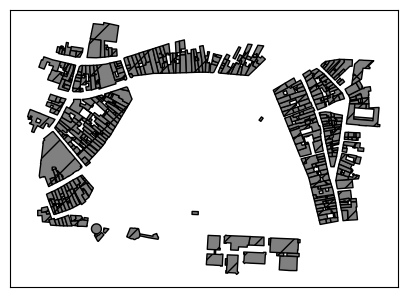

In [27]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')

## Couverture du sol avec différentes couches IGN

In [9]:
from pymdu.geometric import Vegetation, Pedestrian, Water, LandCover

water = Water(output_path="./")
water.bbox = bbox_coords
water_gdf = water.run().to_gdf()

pedestrian = Pedestrian(output_path="./")
pedestrian.bbox = bbox_coords
pedestrian_gdf = pedestrian.run().to_gdf()

vegetation = Vegetation(output_path="./", min_area=100)
vegetation.bbox = bbox_coords
vegetation_gdf = vegetation.run().to_gdf()

landcover = LandCover(
    output_path="./",
    building_gdf=buildings_gdf,
    vegetation_gdf=vegetation_gdf,
    water_gdf=water_gdf,
    cosia_gdf=None,
    dxf_gdf=None,
    pedestrian_gdf=pedestrian_gdf,
    write_file=False,
)
landcover.bbox = bbox_coords
landcover.run()
landcover_gdf = landcover.to_gdf()

[overpass] downloading data: [timeout:25][out:json];(way["natural"="water"](46.181627,-1.152704,46.18699,-1.139893);relation["natural"="water"](46.181627,-1.152704,46.18699,-1.139893);node["natural"="water"](46.181627,-1.152704,46.18699,-1.139893);); out body geom;


{"type":"FeatureCollection","name":"OSMPythonTools","features":[{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-1.147657,46.183413],[-1.147157,46.183211],[-1.146822,46.183103],[-1.146479,46.182971],[-1.146218,46.182815],[-1.146044,46.182602],[-1.146065,46.182177],[-1.146151,46.181804],[-1.146163,46.181986],[-1.146215,46.182176],[-1.146338,46.182384],[-1.146628,46.182625],[-1.147196,46.182988],[-1.147468,46.18321],[-1.147645,46.183374],[-1.147657,46.183413]]]},"properties":{"name":"\"natural\"=\"water\"0"}},{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-1.151472,46.184116],[-1.151612,46.184084],[-1.15164,46.184033],[-1.151535,46.183902],[-1.151411,46.183899],[-1.151321,46.18396],[-1.151291,46.184006],[-1.151321,46.184055],[-1.151472,46.184116]]]},"properties":{"name":"\"natural\"=\"water\"1"}}]}
Index(['Service', 'Thï¿½matique', 'Producteur', 'Nom',
       'URL d'acces Geoportail', 'URL d'acces Geoplateforme',
       'Statut de licence', 'Etat de publi

ERROR 1: _TIFFVSetField:/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/img.tiff: Null count for "GeoDoubleParams" (type 12, writecount -1, passcount 1)
ERROR 1: _TIFFVSetField:/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/img.tiff: Null count for "GeoDoubleParams" (type 12, writecount -1, passcount 1)
/Users/Boris/Documents/TIPEE/pymdu/pymdu/geometric/Vegetation.py:114: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -999 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  dataset_rio.data[0] = filter_raster
/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/Users/Boris/Documents/TIPEE/pymdu/pymdu/geometric

0...10...20...30...40...50...60...70...80...90...

/Users/Boris/.local/lib/python3.11/site-packages/pandas/core/generic.py:6313: DeprecationWarning: Overriding the CRS of a GeoDataFrame that already has CRS. This unsafe behavior will be deprecated in future versions. Use GeoDataFrame.set_crs method instead
  return object.__setattr__(self, name, value)


<Axes: >

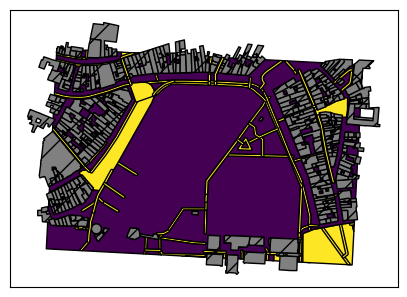

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
landcover_gdf.plot(ax=ax, alpha=1, edgecolor="black", column="type")
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')


## Extraction et tracé cartographique des classes `COSIA` : (Couverture du Sol par Intelligence Artificielle)

Tout d’abord, téléchargez les fichiers `COSIA` correspondant à votre zone d’intérêt.

CoSIA - application pour visualiser et télécharger ses cartes de Couverture du Sol par Intelligence Artificielle.

Le lien est disponible ci-dessous.

https://cosia.ign.fr/info#export

Cette cellule importe les fichiers COSIA, calcule l’intersection avec votre zone d’intérêt, puis génère une carte où chaque polygone est coloré d’après sa classe COSIA.


### Cosia avec donnée brute GeoPackage

In [11]:
from pathlib import Path
from pymdu.geometric.Cosia import Cosia

directory_path = Path.home() / 'Downloads/CoSIA_D017_2021'
# directory_path = Path.home() / 'cosia/CoSIA_D017_2021'
cosia = Cosia(directory_path_cosia=directory_path)
cosia.bbox = bbox_coords
cosia_gdf = cosia.run()
table_color_cosia = cosia.table_color_cosia
cosia_gdf['color'] = [table_color_cosia[x] for x in cosia_gdf.classe]

Index(['Service', 'Thï¿½matique', 'Producteur', 'Nom',
       'URL d'acces Geoportail', 'URL d'acces Geoplateforme',
       'Statut de licence', 'Etat de publication', 'Statut  Gï¿½oplateforme',
       'Date actualisation de la donnï¿½e', 'Remarque'],
      dtype='object')


/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_read(
/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_read(
/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read(
/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_read(
/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'D017_2021_370_6580_vecto.gpkg': 'D017_2021_370_6580_vecto' (default), 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/Boris/miniforge3/envs/pym

<Axes: >

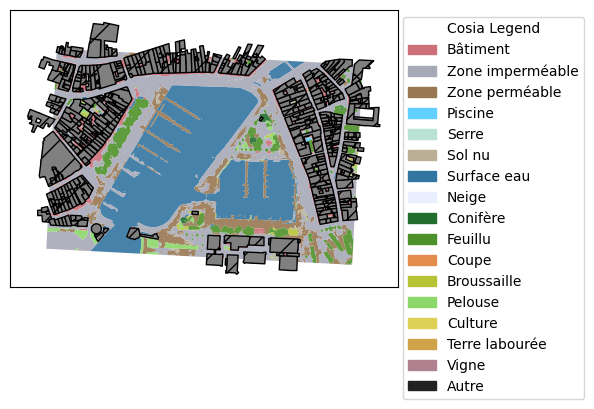

In [12]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))

# Créer les patches pour chaque couleur et sa description dans la légende
patches = [
    mpatches.Patch(color=value, label=label)
    for (value, label) in zip(table_color_cosia.values(), table_color_cosia.keys())
]

# Ajouter la légende personnalisée
plt.legend(
    handles=patches,
    loc="upper right",
    title="Cosia Legend",
    bbox_to_anchor=(1.5, 1.)
)
ax.set_xticks([])
ax.set_yticks([])
cosia_gdf.plot(ax=ax, edgecolor=None, color=cosia_gdf['color'], alpha=0.9)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')

### Cosia avec donnée IGN

In [13]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

cosia_ign = cosia.run_ign()

with rasterio.open(cosia.path_save_tiff) as src:
    band1 = src.read(1)
    band2 = src.read(2)
    band3 = src.read(3)
    mask = band1 != src.nodata  # ignorer les valeurs nodata

    results = (
        {'properties': {'value': v}, 'geometry': s}
        for s, v in shapes(band1, mask=mask, transform=src.transform)
    )

    # Créer un GeoDataFrame à partir des résultats
    geoms = []
    values = []
    for result in results:
        geoms.append(shape(result['geometry']))
        values.append(result['properties']['value'])

cosia_gdf_ign = gpd.GeoDataFrame({'value': values, 'geometry': geoms}, crs=src.crs)

# Afficher un aperçu
cosia_gdf_ign.head(100)

key=> cosia
['IGNF_COSIA_2021-2023_WMS']
https://data.geopf.fr/wms-r/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities
URL  :  /var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/cosia.tiff


ERROR 1: _TIFFVSetField:/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/cosia.tiff: Null count for "GeoDoubleParams" (type 12, writecount -1, passcount 1)


,value,geometry
0,180.0,"POLYGON ((379487.147 6570510.873, 379487.147 6..."
1,204.0,"POLYGON ((379488.147 6570510.873, 379488.147 6..."
2,192.0,"POLYGON ((379487.147 6570509.873, 379487.147 6..."
3,188.0,"POLYGON ((379532.147 6570508.873, 379532.147 6..."
4,200.0,"POLYGON ((379487.147 6570507.873, 379487.147 6..."
...,...,...
95,200.0,"POLYGON ((379527.147 6570498.873, 379527.147 6..."
96,172.0,"POLYGON ((379528.147 6570498.873, 379528.147 6..."
97,204.0,"POLYGON ((379537.147 6570498.873, 379537.147 6..."
98,204.0,"POLYGON ((379585.147 6570498.873, 379585.147 6..."


<Axes: >

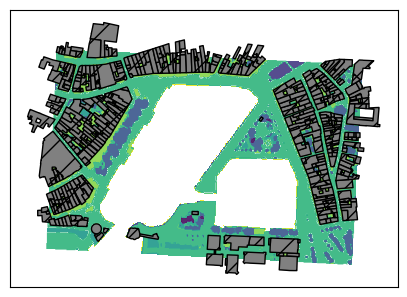

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
cosia_gdf_ign.plot(ax=ax, edgecolor=None, column='value', alpha=0.9)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')

## Couverture du sol avec différentes avec `COSIA`

In [15]:
from pymdu.geometric.LandCover import LandCover

landcover = LandCover(output_path=output_path,
                      building_gdf=None,
                      vegetation_gdf=None,
                      cosia_gdf=cosia_gdf,
                      dxf_gdf=None,
                      pedestrian_gdf=None,
                      water_gdf=None)

landcover_gdf = landcover.run(keep_geom_type=True).to_gdf()
landcover.bbox = bbox_coords
landcover.to_shp(name='landcover')

landcover.create_landcover_from_cosia(os.path.join(inputs_simulation_path, "landcover.tif"))

<Axes: title={'center': 'Landcover (Cosia)'}>

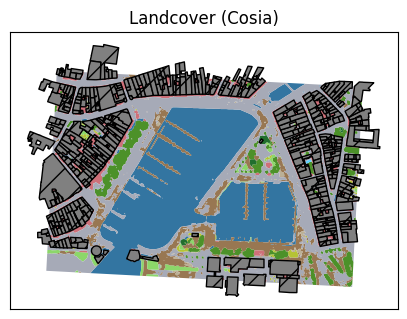

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
plt.title('Landcover (Cosia)')
landcover.gdf.plot(ax=ax, color=landcover_gdf["color"], alpha=1)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')

## Création de la couche `DEM` : (Digital Elevation Model)

Dans cette section, nous procédons à la création de la couche DEM (Digital Elevation Model), qui représente le modèle numérique de terrain pour la zone d'étude. Les données nécessaires à la construction de cette couche sont téléchargées à partir du serveur de l'IGN (Institut Géographique National), garantissant ainsi une haute précision et une couverture complète du territoire concerné.


Le DEM ne prend pas en compte les objets présents à la surface du terrain tels que les plantes et les bâtiments.

In [17]:
from pymdu.geometric.Dem import Dem

dem = Dem(output_path=inputs_simulation_path)
dem.bbox = bbox_coords
dem.run()

Index(['Service', 'Thï¿½matique', 'Producteur', 'Nom',
       'URL d'acces Geoportail', 'URL d'acces Geoplateforme',
       'Statut de licence', 'Etat de publication', 'Statut  Gï¿½oplateforme',
       'Date actualisation de la donnï¿½e', 'Remarque'],
      dtype='object')
key=> dem
['ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES'
 'ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES']
https://data.geopf.fr/wms-r/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities
URL  :  /var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/dem.tiff


ERROR 1: _TIFFVSetField:/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/dem.tiff: Null count for "GeoDoubleParams" (type 12, writecount -1, passcount 1)


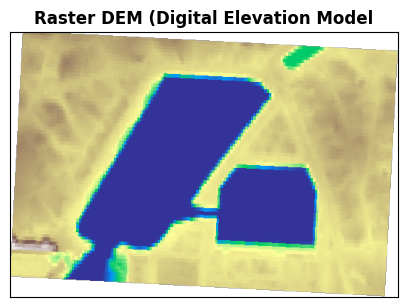

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(inputs_simulation_path, "DEM.tif"))
im = rasterio.plot.show(raster, ax=ax, title="Raster DEM (Digital Elevation Model", cmap='terrain')
# Ajouter la barre de couleur
# fig.colorbar(im, ax=ax, orientation='vertical', label='Elevation')
plt.show()

## Découpage et reprojection du DEM avec GDAL

In [19]:
import subprocess

inraster = os.path.join(inputs_simulation_path, "DEM.tif")
outraster = os.path.join(output_path, "DEM.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")
subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])

Creating output file that is 453P x 309L.
Using internal nodata values (e.g. -99999) for image /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DEM.tif.
Copying nodata values from source /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DEM.tif to destination /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DEM.tif.
Processing /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DEM.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


0

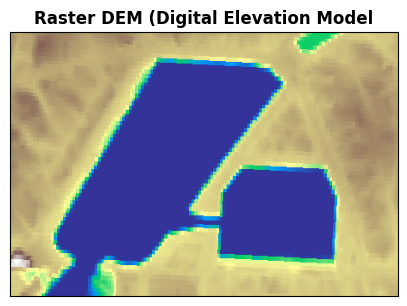

In [20]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "DEM.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster DEM (Digital Elevation Model", cmap='terrain')
plt.show()

## Homégénéisation des rasters

Dans cette étape, nous procédons à l'homogénéisation des rasters utilisés pour les différentes couches géospatiales. Lors de la manipulation des données raster, les différences de projections peuvent entraîner des décalages spatiaux entre les couches, ce qui pourrait compromettre la précision des analyses.

Pour garantir que les résultats des simulations soient cohérents et fiables, il est essentiel de s'assurer que tous les rasters ont la même taille et les mêmes dimensions.


In [21]:
from osgeo import gdal, gdalconst
from pymdu.image.geotiff import raster_file_like

gdal.AllRegister()
warp_options = gdal.WarpOptions(format='GTiff',
                                xRes=1, yRes=1,
                                outputType=gdalconst.GDT_Float32,
                                dstNodata=None,
                                dstSRS='EPSG:2154',
                                cropToCutline=True,
                                cutlineDSName=os.path.join(inputs_simulation_path, 'mask.shp'),
                                cutlineLayer='mask')

gdal.Warp(destNameOrDestDS=os.path.join(output_path, 'landcover_clip.tif'),
          srcDSOrSrcDSTab=os.path.join(inputs_simulation_path, 'landcover.tif'),
          options=warp_options)

raster_file_like(src_tif=os.path.join(output_path, "landcover_clip.tif"),
                 dst_tif=os.path.join(output_path, "landcover.tif"),
                 like_path=os.path.join(output_path, "DEM.tif"),
                 remove_nan=True)

Pas besoin de re-découper


<xarray.DataArray (band: 1, y: 309, x: 453)> Size: 560kB
array([[[2., 2., ..., 2., 2.],
        [2., 2., ..., 2., 2.],
        ...,
        [1., 1., ..., 6., 6.],
        [1., 1., ..., 6., 6.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 3.795e+05 3.795e+05 ... 3.8e+05 3.8e+05
  * y            (y) float64 2kB 6.57e+06 6.57e+06 ... 6.57e+06 6.57e+06
    spatial_ref  int64 8B 0
Attributes:
    long_name:      type
    name:           type
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

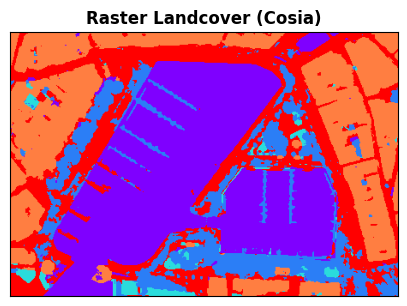

In [22]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "landcover.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster Landcover (Cosia)", cmap='rainbow_r')
plt.show()

## Extraction des arbres à partir de données LiDAR

Le LiDAR (Light Detection And Ranging) est une méthode de télédétection par laser qui fournit un nuage de points 3D extrêmement précis de la surface du sol et de la végétation.

Dans cette étape, nous exploitons ces données pour détecter les arbres au sein de notre zone d’intérêt.
Avec la classe `Lidar` de `pymdu` :
- Nous chargeons les données LiDAR,
- Appliquons la bounding box définie précédemment,
- Exécutons l’algorithme de détection des arbres,
- Et exportons les emplacements des arbres sous forme de shapefile.

In [23]:
from pymdu.image.Lidar import Lidar

lidar = Lidar(output_path=inputs_simulation_path)
lidar.bbox = bbox_coords
lidar_tif = lidar.to_tif(write_out_file=True, classification_list=[3, 4, 5, 9])

<Response [200]>


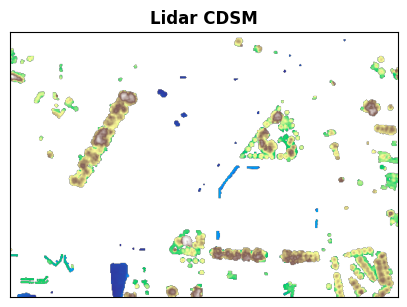

In [24]:
%matplotlib inline
# Lire les données et les afficher avec rasterio.plot
with lidar_tif.open() as src:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks([])
    ax.set_yticks([])
    rasterio.plot.show(src, ax=ax, title="Lidar CDSM", cmap='terrain')
    plt.show()

In [25]:
lidar_trees_gdf = lidar.run_trees()
lidar_trees_gdf.to_file(os.path.join(inputs_simulation_path, 'lidar_trees.shp'))

<Response [200]>
Projected BBOX (EPSG:2154): [379469.14715032035, 380001.58724372747, 6570174.188856952, 6570483.784653484]
DSM.tif saved successfully.
DTM.tif saved successfully.
CHM.tif saved successfully.
Detected 32 tree top candidates.
Extracted 32 crown polygons.
Tree crowns saved to 'tree_crowns.shp'.
Tree tops saved to 'tree_tops.shp'.


/Users/Boris/Documents/TIPEE/pymdu/pymdu/image/Lidar.py:345: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_crowns.to_file(crown_shp)
/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'tree_height' to 'tree_heigh'
  ogr_write(
/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'trunk_height' to 'trunk_heig'
  ogr_write(


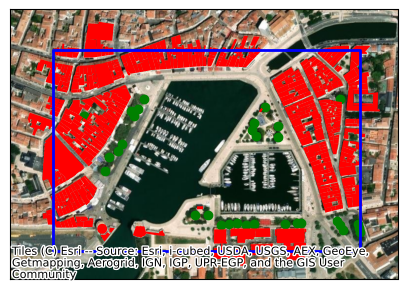

In [26]:
%matplotlib inline
# 1. Create the bbox polygon in WGS84 (EPSG:4326)

bbox_poly = gpd.GeoSeries([box(*bbox_coords)], crs="EPSG:4326")

# 2. Convert all layers to Web Mercator (EPSG:3857)
lidar_trees_3857 = lidar_trees_gdf.to_crs(epsg=3857)
buildings_3857 = buildings_gdf.to_crs(epsg=3857)
bbox_3857 = bbox_poly.to_crs(epsg=3857)

# 3. Plot everything, including the bbox
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])

lidar_trees_3857.plot(ax=ax, color='g', alpha=1)
buildings_3857.plot(ax=ax, color='r', alpha=1)
bbox_3857.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

plt.show()


# Utilisation automatique du plugin UMEP de QGIS

 1. Télécharger https://github.com/UMEP-dev/UMEP-processing -> renommer processing_umep
 2. Coller dans le répertoire : `.local/share/QGIS/QGIS3/profiles/default/python/plugins` ou

`[...]/envs/pymdu/share/qgis/python/plugins`


## Construction de la couche `DSM` : (Digital Surface Model)

Dans cette étape, nous procédons à la construction de la couche `DSM` (Digital Surface Model), qui est représentée par le fichier `DSM.tif`.

Dans le cadre du code `Solweig`, cette couche joue un rôle essentiel car elle représente la hauteur des éléments présents à la surface, tels que les bâtiments, la végétation, et autres structures. Contrairement au modèle numérique de terrain (DEM) qui ne prend en compte que la topographie du sol, le DSM inclut l'élévation des objets se trouvant au-dessus du sol.

In [28]:
from pymdu.physics.umep.DsmModelGenerator import DsmModelGenerator

dsm = DsmModelGenerator(
    working_directory=inputs_simulation_path,
    output_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),
    input_filepath_dem=os.path.join(inputs_simulation_path, "DEM.tif"),
    input_building_shp_path=os.path.join(inputs_simulation_path, "buildings.shp"),
    input_mask_shp_path=os.path.join(inputs_simulation_path, "mask.shp")

)
dsm.run()

inraster = os.path.join(inputs_simulation_path, f"DSM.tif")
outraster = os.path.join(output_path, f"DSM.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")

subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])

__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
extent 379509.0801573259,379961.654236722,6570174.381785381,6570483.590226257 [EPSG:2154]


/Users/Boris/miniforge3/envs/pymdu/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DRIVER
  return ogr_read(


Processing UMEP umep:Spatial Data: DSM Generator
{'INPUT_DEM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DEM.tif', 'INPUT_POLYGONLAYER': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/buildings.shp', 'INPUT_FIELD': 'hauteur', 'USE_OSM': False, 'BUILDING_LEVEL': 3.1, 'EXTENT': '379509.0801573259,379961.654236722,6570174.381785381,6570483.590226257 [EPSG:2154]', 'PIXEL_RESOLUTION': 1, 'OUTPUT_DSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif'}
Processing UMEP EXIT umep:Spatial Data: DSM Generator
Creating output file that is 453P x 309L.
Using internal nodata values (e.g. -9999) for image /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif.
Copying nodata values from source /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif to destination /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DSM.tif.
Processing /Users/Boris/Documents/TIPEE

0

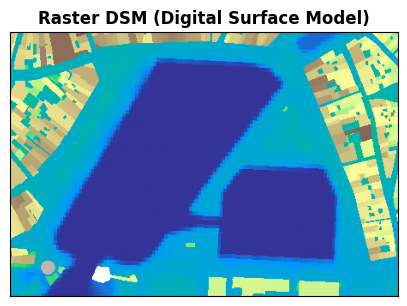

In [29]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "DSM.tif"))
img = rasterio.plot.show(raster, ax=ax, title="Raster DSM (Digital Surface Model)", cmap='terrain')
plt.show()

j## Construction de la couche `CDSM` et `TDSM`

Dans cette étape, nous procédons à la construction des couches `CDSM` (Canopy Digital Surface Model) et `TDSM` (Tree Digital Surface Model), qui sont essentielles pour les simulations dans le cadre du code `Solweig`. La couche `CDSM` représente un modèle numérique de surface spécifique à la canopée urbaine, c'est-à-dire les éléments au-dessus du sol qui ne sont pas des bâtiments, principalement des haies et le tronc des arbres.

De son côté, la couche `TDSM` est dédiée à la représentation des arbres. Elle modélise l'élévation des arbres, ce qui permet d'analyser leur contribution à la régulation thermique et à la réduction des îlots de chaleur en milieu urbain.


In [30]:
from pymdu.physics.umep.SurfaceModelGenerator import SurfaceModelGenerator

trees_path = os.path.join(inputs_simulation_path, 'lidar_trees.shp')

surface_model = SurfaceModelGenerator(
    working_directory=inputs_simulation_path,
    input_filepath_dsm=os.path.join(output_path, "DSM.tif"),
    input_filepath_dem=os.path.join(output_path, "DEM.tif"),
    input_filepath_tree_shp=trees_path,
    output_filepath_cdsm=os.path.join(inputs_simulation_path, "CDSM.tif"),
    output_filepath_tdsm=os.path.join(inputs_simulation_path, "TDSM.tif")
)
surface_model.run()
list_files = ['CDSM', 'TDSM']

for file in list_files:
    inraster = os.path.join(inputs_simulation_path, f"{file}.tif")
    outraster = os.path.join(output_path, f"{file}.tif")
    inshape = os.path.join(inputs_simulation_path, "mask.shp")

    subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                     '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                     'Float32'])

__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Spatial Data: Tree Generator
{'INPUT_POINTLAYER': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/lidar_trees.shp', 'TREE_TYPE': 'type', 'TOT_HEIGHT': 'height', 'TRUNK_HEIGHT': 'trunk zone', 'DIA': 'diameter', 'INPUT_BUILD': None, 'INPUT_DSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DSM.tif', 'INPUT_DEM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DEM.tif', 'INPUT_CDSM': None, 'INPUT_TDSM': None, 'CDSM_GRID_OUT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/CDSM.tif', 'TDSM_GRID_OUT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/TDSM.tif'}
Processing UMEP EXIT umep:Spatial Data: Tree Generator
Creating output file that is 453P x 309L.
Processing /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/CDSM.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...10

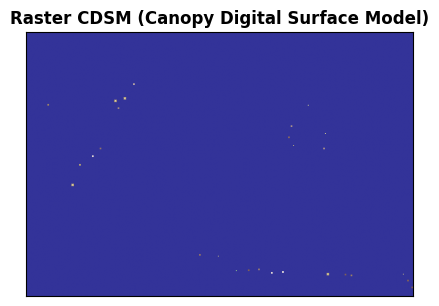

In [31]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(inputs_simulation_path, "CDSM.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster CDSM (Canopy Digital Surface Model)", cmap='terrain')
plt.show()

## Construction de la couche `HEIGHT` et `ASPECT`

Dans cette étape, nous procédons à la construction des couches `HEIGHT` et `ASPECT`, qui jouent un rôle crucial dans les simulations climatiques effectuées avec le code `Solweig`.

La couche `HEIGHT` représente la hauteur des structures urbaines, telles que les bâtiments, par rapport au niveau du sol. Cette information est fondamentale pour évaluer l'impact des différentes hauteurs sur la distribution des ombres, la répartition des rayonnements solaires, et, par conséquent, sur la température ressentie dans l'environnement urbain.

La couche `ASPECT`, indique l'orientation des pentes et des surfaces par rapport aux points cardinaux. Cette orientation est essentielle pour comprendre comment les surfaces captent ou réfléchissent la lumière du soleil tout au long de la journée, influençant directement la distribution des températures et des conditions microclimatiques au sein du quartier.


In [32]:
from pymdu.physics.umep.HeightAspectModelGenerator import HeightAspectModelGenerator

height_aspect_model = HeightAspectModelGenerator(
    working_directory=inputs_simulation_path,
    output_filepath_height=os.path.join(inputs_simulation_path, "HEIGHT.tif"),
    output_filepath_aspect=os.path.join(inputs_simulation_path, "ASPECT.tif"),
    input_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),

)
height_aspect_model.run()

list_files = ['HEIGHT', 'ASPECT']

for file in list_files:
    inraster = os.path.join(inputs_simulation_path, f"{file}.tif")
    outraster = os.path.join(output_path, f"{file}.tif")
    inshape = os.path.join(inputs_simulation_path, "mask.shp")

    subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                     '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                     'Float32'])


__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Urban Geometry: Wall Height and Aspect
{'INPUT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif', 'INPUT_LIMIT': 3, 'OUTPUT_HEIGHT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/HEIGHT.tif', 'OUTPUT_ASPECT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/ASPECT.tif'}
Processing UMEP EXIT umep:Urban Geometry: Wall Height and Aspect
Creating output file that is 453P x 309L.
Processing /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/HEIGHT.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 453P x 309L.
Processing /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/ASPECT.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


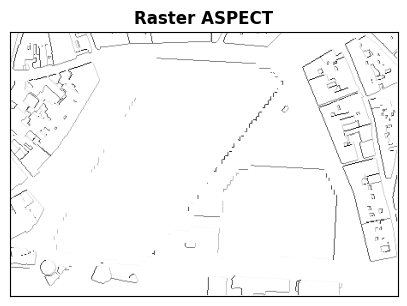

In [35]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "ASPECT.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster ASPECT", cmap='binary')
plt.show()

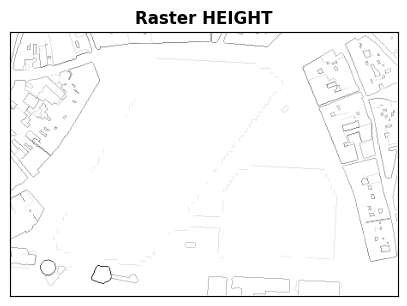

In [34]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "HEIGHT.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster HEIGHT", cmap='binary')
plt.show()

## Construction de la couche `SkyViewFactor`

Dans cette étape, nous procédons à la construction de la couche `SkyViewFactor`, qui est une composante essentielle pour les simulations climatiques dans le cadre du code `Solweig`. Le Sky View Factor (SVF) est un indicateur qui mesure la proportion du ciel visible depuis un point donné au sol. Il est particulièrement important dans les environnements urbains denses, où les bâtiments et autres structures peuvent obstruer la vue du ciel, réduisant ainsi l'exposition au rayonnement solaire direct et affectant la température ressentie.

`Solweig` se distingue par sa capacité à utiliser des Sky View Factors directionnels, ce qui signifie qu'il prend en compte la visibilité du ciel dans différentes directions (nord, sud, est, ouest) pour chaque point de la zone étudiée. Cette approche directionnelle permet une modélisation plus fine des interactions entre les bâtiments, les ombres, et le climat urbain.


In [36]:
from pymdu.physics.umep.SVFModelGenerator import SVFModelGenerator

svf_model = SVFModelGenerator(
    working_directory=output_path,
    input_filepath_tdsm=os.path.join(inputs_simulation_path, "TDSM.tif"),
    input_filepath_cdsm=os.path.join(inputs_simulation_path, "CDSM.tif"),
    input_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),
    ouptut_filepath_svf=os.path.join(inputs_simulation_path, "SVF.tif"),
)
svf_model.run()

inraster = os.path.join(inputs_simulation_path, "SVF.tif")
outraster = os.path.join(output_path, "SVF_clip.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")

subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])


__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Urban Geometry: Sky View Factor
{'INPUT_DSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif', 'INPUT_CDSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/CDSM.tif', 'TRANS_VEG': 3, 'INPUT_TDSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/TDSM.tif', 'INPUT_THEIGHT': 25.0, 'ANISO': True, 'OUTPUT_DIR': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo', 'OUTPUT_FILE': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/SVF.tif'}
Processing UMEP EXIT umep:Urban Geometry: Sky View Factor
Creating output file that is 453P x 309L.
Using internal nodata values (e.g. -9999) for image /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/SVF.tif.
Copying nodata values from source /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/SVF.tif to dest

0

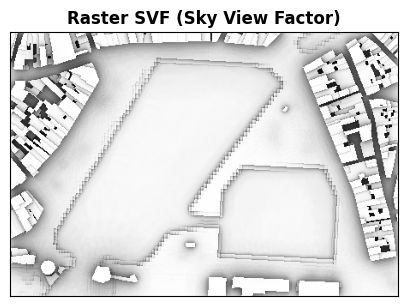

In [37]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "SVF_clip.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster SVF (Sky View Factor)", cmap='gray')
plt.show()

## Météo

In [38]:
from pymdu.meteo.Meteo import Meteo

meteo_file = Meteo(output_path=r"./")
meteo_file.bbox = bbox_coords
meteo_file.run(
    begin='2018-06-30 00:00:00',
    end='2018-06-30 23:00:00'
)


## Calcul de la température moyenne radiante

In [39]:
from pymdu.physics.umep.Solweig import Solweig

d = Solweig(meteo_path='FRA_AC_La.Rochelle.073150_TMYx.2004-2018.txt',
            output_dir=output_path,
            working_directory=output_path,
            input_filepath_landcover=os.path.join(output_path, "landcover.tif"),
            input_filepath_dsm=os.path.join(output_path, "DSM.tif"),
            input_filepath_dem=os.path.join(output_path, "DEM.tif"),
            input_filepath_cdsm=os.path.join(output_path, "CDSM.tif"),
            input_filepath_tdsm=os.path.join(output_path, "TDSM.tif"),
            input_filepath_height=os.path.join(output_path, "HEIGHT.tif"),
            input_filepath_aspect=os.path.join(output_path, "ASPECT.tif"),
            input_filepath_shadowmats_npz=os.path.join(output_path, "shadowmats.npz"),
            input_filepath_svf_zip=os.path.join(output_path, "svfs.zip"))
d.run()



__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Outdoor Thermal Comfort: SOLWEIG
{'INPUT_DSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DSM.tif', 'INPUT_SVF': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/svfs.zip', 'INPUT_HEIGHT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/HEIGHT.tif', 'INPUT_ASPECT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/ASPECT.tif', 'INPUT_CDSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/CDSM.tif', 'TRANS_VEG': 3, 'INPUT_TDSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/TDSM.tif', 'INPUT_THEIGHT': 25, 'INPUT_LC': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/landcover.tif', 'USE_LC_BUILD': False, 'INPUT_DEM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DSM.tif', 'SAVE_BUILD': False, 'INPUT_ANISO': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/shadowmats.npz', 'ALBEDO_WALLS': 0.2, 'ALBEDO_GROUND': 0.15, 'EMIS_WALL

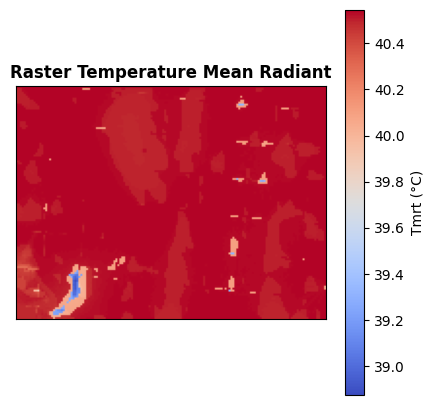

In [74]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "Tmrt_average.tif"))
img = rasterio.plot.show(raster, ax=ax, title="Raster Temperature Mean Radiant", cmap='coolwarm')
plt.colorbar(img.get_images()[0], ax=ax, label='Tmrt (°C)')
plt.show()

## Lancement UROCK : (Urban Wind Field)

In [40]:
import geopandas as gpd
from pymdu.geometric.UrockFiles import UrockFiles

batiments = gpd.read_file(os.path.join(inputs_simulation_path, 'buildings.shp'))
arbres = gpd.read_file(os.path.join(inputs_simulation_path, 'lidar_trees.shp'))

urock = UrockFiles(output_path, batiments, arbres)
urock.generate_urock_buildings().to_file(os.path.join(output_path, 'batiments_urock.shp'), driver="ESRI Shapefile")
urock.generate_urock_trees().to_file(os.path.join(output_path, 'arbres_urock.shp'), driver="ESRI Shapefile")

In [41]:
from pymdu.physics.umep.UmepCore import UmepCore

for direction in range(50, 55, 10):
    options_umep_urock = {
        'BUILDINGS': os.path.join(output_path, 'batiments_urock.shp'),
        'HEIGHT_FIELD_BUILD': 'hauteur',
        'VEGETATION': os.path.join(output_path, 'arbres_urock.shp'),
        'VEGETATION_CROWN_TOP_HEIGHT': 'MAX_HEIGHT',
        'VEGETATION_CROWN_BASE_HEIGHT': 'MIN_HEIGHT',
        'ATTENUATION_FIELD': 'ATTENUATIO',
        'INPUT_PROFILE_FILE': '',
        'INPUT_PROFILE_TYPE': 0,
        'INPUT_WIND_HEIGHT': 10,
        'INPUT_WIND_SPEED': 1,
        'INPUT_WIND_DIRECTION': direction,
        'RASTER_OUTPUT': None,
        'HORIZONTAL_RESOLUTION': 1,
        'VERTICAL_RESOLUTION': 10,
        'WIND_HEIGHT': '2',
        'UROCK_OUTPUT': output_path_urock,
        'OUTPUT_FILENAME': f'output_{direction}',
        'SAVE_RASTER': False,
        'SAVE_VECTOR': False,
        'SAVE_NETCDF': True,
        'LOAD_OUTPUT': True
    }

    umep_core = UmepCore(output_dir=output_path_urock)

    umep_core.run_processing(
        name="umep:Urban Wind Field: URock",
        options=options_umep_urock
    )

__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Urban Wind Field: URock
{'BUILDINGS': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/batiments_urock.shp', 'HEIGHT_FIELD_BUILD': 'hauteur', 'VEGETATION': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/arbres_urock.shp', 'VEGETATION_CROWN_TOP_HEIGHT': 'MAX_HEIGHT', 'VEGETATION_CROWN_BASE_HEIGHT': 'MIN_HEIGHT', 'ATTENUATION_FIELD': 'ATTENUATIO', 'INPUT_PROFILE_FILE': '', 'INPUT_PROFILE_TYPE': 0, 'INPUT_WIND_HEIGHT': 10, 'INPUT_WIND_SPEED': 1, 'INPUT_WIND_DIRECTION': 50, 'RASTER_OUTPUT': None, 'HORIZONTAL_RESOLUTION': 1, 'VERTICAL_RESOLUTION': 10, 'WIND_HEIGHT': '2', 'UROCK_OUTPUT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/output_urock', 'OUTPUT_FILENAME': 'output_50', 'SAVE_RASTER': False, 'SAVE_VECTOR': False, 'SAVE_NETCDF': True, 'LOAD_OUTPUT': True}
Connecting to database
	->/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/myDbH21750670616_7470589
/Users/Bori

SLF4J(W): No SLF4J providers were found.
SLF4J(W): Defaulting to no-operation (NOP) logger implementation
SLF4J(W): See https://www.slf4j.org/codes.html#noProviders for further details.


Spatial functions added!

Load input data
Load table 'build_pre_srid_20250623112338'
Load table 'veg_pre_srid_20250623112338'
Creates blocks and stacked blocks
Rotates geometries from 50.0 degrees
Identify block base height and block cavity base
Calculates obstacle properties
Calculates zone properties
Initializes upwind facades
Update upwind facades base height
Initializes downwind facades
Calculates study area properties
Roughness zone properties are:

                                 - z0: 1.0471534870438226
                                 - d: 3.9919850322125745
                                 - Hr: 14.138873172227598
                                 - H_ob_max: 30.0
                                 - lambda_f: 0.07406201854195162
Rotates geometries from -50.0 degrees
Creates displacement zones
Creates cavity and wake zones
Creates street canyon zones
Creates rooftop zones (perpendicular and corner)
Creates built-up and open vegetation zones
Creates the grid of points
Affects eac

## Post-traitement :  Tif to netCDF


In [42]:
import numpy as np
import rasterio
from pyproj import Transformer

import os

TMRT_PATH = os.path.join(output_path, 'Tmrt_average.tif')
with rasterio.open(TMRT_PATH) as tif:
    temp = tif.read(1)
    tif_transform = tif.transform
    tif_crs = tif.crs
    tif_width = tif.width
    tif_height = tif.height
    print('tif crs, tif transform', tif_crs, tif_transform)
    print('tif width, tif height:', tif_width, tif_height)

    rows, cols = np.meshgrid(np.arange(tif_height), np.arange(tif_width), indexing='ij')
    xs, ys = rasterio.transform.xy(tif_transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

# Flatten for reprojection
xs_flat = xs.flatten()
ys_flat = ys.flatten()

# Set up a transformer from EPSG:2154 to WGS84
transformer = Transformer.from_crs(tif_crs, "EPSG:4326", always_xy=True)
lons_flat, lats_flat = transformer.transform(xs_flat, ys_flat)

# Reshape to tif grid shape
lons = lons_flat.reshape(xs.shape)
lats = lats_flat.reshape(ys.shape)


tif crs, tif transform EPSG:2154 | 1.00, 0.00, 379509.08|
| 0.00,-1.00, 6570483.59|
| 0.00, 0.00, 1.00|
tif width, tif height: 453 309


In [43]:
from netCDF4 import Dataset
import numpy as np

direction = 50
file_name = f'output_{direction}.nc'
file_nc = os.path.join(output_path_urock, file_name)

nc = Dataset(file_nc)
group = nc.groups['3D_wind']

lon = group.variables['lon'][:]
lat = group.variables['lat'][:]

Z = group.variables['Z'][:]
level_idx = np.argmin(np.abs(Z - 10))  # 10 meter

wind_x = group.variables['windSpeed_x'][:, :, level_idx]
wind_y = group.variables['windSpeed_y'][:, :, level_idx]
wind_z = group.variables['windSpeed_z'][:, :, level_idx]

wind_speed = np.sqrt(wind_x ** 2 + wind_y ** 2 + wind_z ** 2)

# flatten for interpolation
points = np.column_stack((lon.flatten(), lat.flatten()))
values = wind_speed.flatten()

from scipy.interpolate import griddata

# interpolate from (lons,lats) from TIF
wind_speed_on_tif = griddata(points, values, (lons, lats), method='linear')
wind_as_array = wind_speed_on_tif.reshape(tif_height, tif_width)

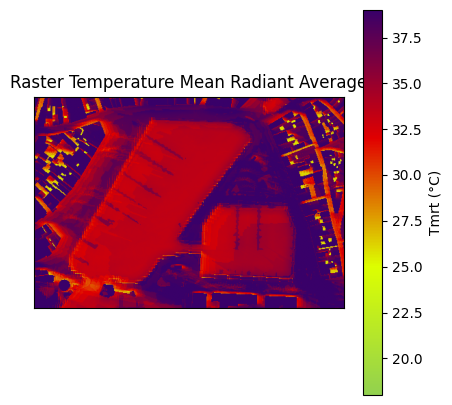

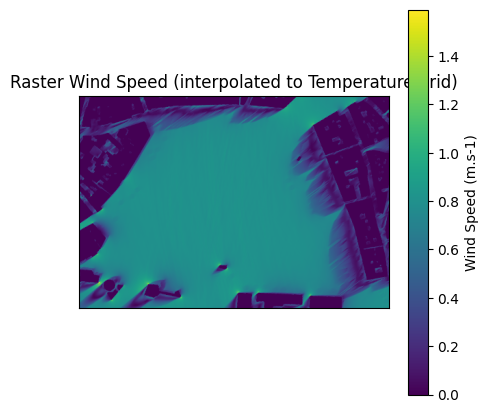

In [44]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
%matplotlib inline

boundaries = [18, 21, 28, 35, 39]
colors = ['#92d14f', '#ddff00', '#e10000', '#390069']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
norm = Normalize(vmin=min(boundaries), vmax=max(boundaries))

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
img = plt.imshow(temp, cmap=cmap, norm=norm)
plt.colorbar(img, ax=ax, label='Tmrt (°C)')
plt.title('Raster Temperature Mean Radiant Average')
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
img = plt.imshow(wind_as_array)
plt.colorbar(img, ax=ax, label='Wind Speed (m.s-1)')
plt.title('Raster Wind Speed (interpolated to Temperature grid)')
plt.show()

## Calcul de l'UTCI : (Universal Thermal Climate Index)

In [45]:
from pymdu.physics.umep.UmepCore import UmepCore

src_nc = os.path.join(output_path_urock, f'output_{direction}.nc')
umep_core = UmepCore(output_dir=output_path_urock)

options_umep_urock_analyze = {
    'INPUT_LINES': None,
    'IS_STREAM': False,
    'ID_FIELD_LINES': '',
    'INPUT_POLYGONS': None,
    'ID_FIELD_POLYGONS': '',
    'INPUT_WIND_FILE': src_nc,
    'SIMULATION_NAME': '',
    'OUTPUT_DIRECTORY': output_path_urock
}
umep_core.run_processing(
    name="umep:Urban Wind Field: URock analyzer",
    options=options_umep_urock_analyze
)


__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Urban Wind Field: URock analyzer
{'INPUT_LINES': None, 'IS_STREAM': False, 'ID_FIELD_LINES': '', 'INPUT_POLYGONS': None, 'ID_FIELD_POLYGONS': '', 'INPUT_WIND_FILE': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/output_urock/output_50.nc', 'SIMULATION_NAME': '', 'OUTPUT_DIRECTORY': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/output_urock'}
Connecting to database
	->/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/myDbH21750670969_068386
/Users/Boris/miniforge3/envs/pymdu/share/qgis/python/plugins/processing_umep/functions/URock/h2gis-standalone/h2gis-dist-2.2.3.jar
Connected!

Spatial functions added!

Processing UMEP EXIT umep:Urban Wind Field: URock analyzer


In [46]:
import numpy as np
import pandas as pd
import rioxarray
from tqdm import tqdm
from pythermalcomfort.models import utci
import os


def wind_a_10m_vectorized(x):
    return x * np.log(10 / 0.01) / np.log(np.minimum(1.5, 10) / 0.01)


output_path = os.path.join(os.getcwd(), 'results_demo')
output_path_urock = os.path.join(output_path, 'output_urock')
os.makedirs(output_path_urock, exist_ok=True)

METEO_FILE = 'FRA_AC_La.Rochelle.073150_TMYx.2004-2018.txt'
METEO_DATA = pd.read_csv(METEO_FILE, sep=' ')

direction = 50
wind_velocity = 4.1
HEURE = 16

TMRT_PATH = os.path.join(output_path, 'Tmrt_average.tif')
TMRT_dataset = rioxarray.open_rasterio(TMRT_PATH)
tmr_as_array = TMRT_dataset.data[0]
size1, size2 = tmr_as_array.shape

wind_as_array_speed = wind_velocity * wind_a_10m_vectorized(wind_as_array)

output = np.zeros(shape=(size1, size2))
tdb = METEO_DATA[METEO_DATA.it == HEURE].Td.values[0]
rh = METEO_DATA[METEO_DATA.it == HEURE].RH.values[0]
for i in tqdm(range(0, size1)):
    output[i, :] = utci(tdb=tdb, tr=tmr_as_array[i, :], v=wind_as_array_speed[i, :], rh=rh, limit_inputs=False)
UTCI_dataset = TMRT_dataset.copy()
UTCI_dataset.data[0] = output


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 10412.47it/s]


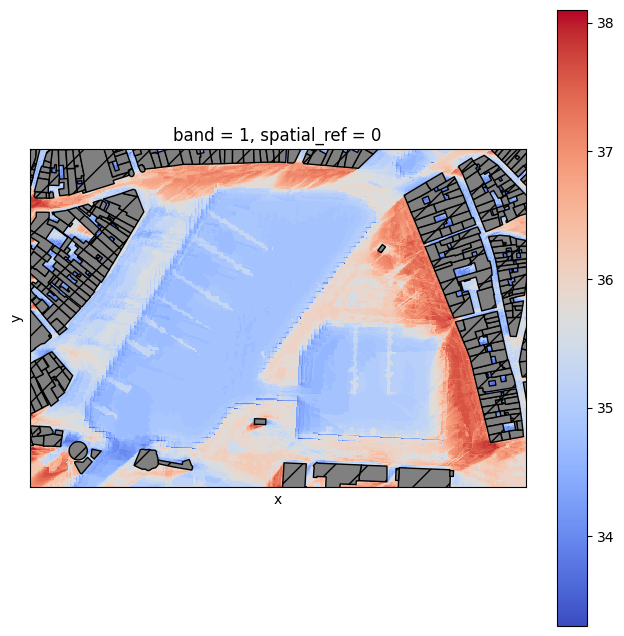

In [50]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

inputs_simulation_path = os.path.join(os.getcwd(), 'results_demo/inputs_simulation')

#boundaries = [21, 21, 28, 35, 42, 46, 53]
boundaries = [-40, -27, -13, 0, 9, 26, 32, 38, 46]
colors = ['#00007f', '#0301c1', '#0000fb', '#0061fe', '#01c0fd', '#00c000', '#ff6601', '#ff3200', '#cc0001', '#7e0305']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=10)
norm = Normalize(vmin=min(boundaries), vmax=max(boundaries))

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
plt.title("UTCI (Universal Thermal Climate Index)")
UTCI_dataset.plot(ax=ax, cmap="coolwarm", norm=None, add_colorbar=True)
# lidar_trees_gdf.to_crs(2154).plot(ax=ax, color='g', alpha=1)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')
plt.show()